# Classification of Citrus Leaves with ResNet50

## Create Dataloader

In [44]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [28]:
# class label is name of sub directory, images are in sub directory
class CitrusLeavesDataset(Dataset):
    def __init__(self, img_dir, transform = None, target_transform = None):
        # define main directory of images and transformations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # store paths and labels in DataFrame
        data = { "image_path" : [], "label" : [] }
        for sub_dir in os.listdir(img_dir):
            for file in os.listdir(os.path.join(img_dir, sub_dir)):
                data['image_path'].append(os.path.join(img_dir, sub_dir, file))
                data['label'].append(sub_dir)

        # store in annotations
        self.annotations = pd.DataFrame(data)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image path and label
        image = read_image(self.annotations.iloc[idx, 0])
        label = self.annotations.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [94]:
TRAIN_PROPORTION = 0.8
BATCH_SIZE = 32
EPOCHS = 40

In [73]:
# load data
citrus_leaves_dataset = CitrusLeavesDataset(img_dir = "./data_citrus_leaves/")

# get train size and test size
train_size = int(TRAIN_PROPORTION * len(citrus_leaves_dataset))
test_size = len(citrus_leaves_dataset) - train_size

# split data
train_dataset, test_dataset = torch.utils.data.random_split(citrus_leaves_dataset, [train_size, test_size])

# create data loaders
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [92]:
# get information on dataset
class_names = citrus_leaves_dataset.annotations['label'].unique()
print("Classes:", class_names)
print("Dataset length:", len(citrus_leaves_dataset))

Classes: ['black_spot' 'canker' 'greening' 'healthy' 'melanose']
Dataset length: 609


The dataset contains $609$ images of healthy and unhealthy leaves. The images are in PNG format and have size $256\times256$.

There are five classes: `black_spot`, `canker`, `greening`, `healthy`, and `melanose`.

In [98]:
citrus_leaves_dataset[0][0].numpy().transpose(1, 2, 0).shape

(1417, 1520, 3)

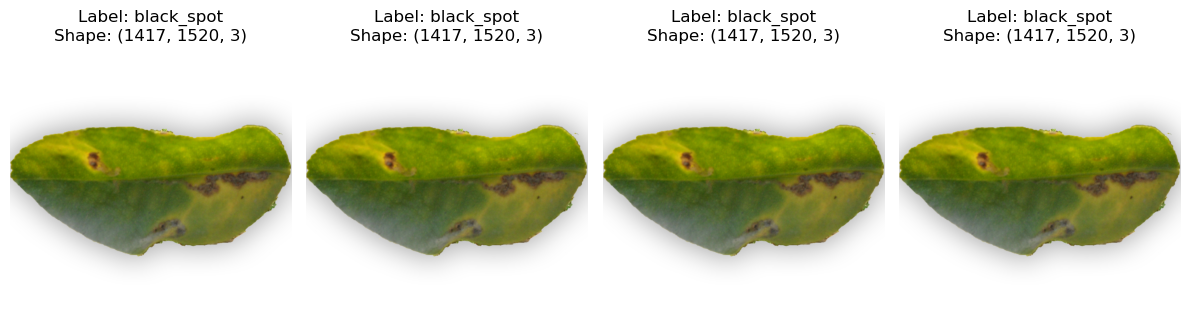

In [101]:
# show random sample images
fig, axes = plt.subplots(1, 4, figsize = (12, 5))
for i in range(4):
    image, label = citrus_leaves_dataset[0]
    image = image.numpy().transpose(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title("Label: {}\nShape: {}".format(label, image.shape))
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [93]:
# load ResNet50 model
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained = True)

Using cache found in C:\Users\fongc/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# do transfer learning on model
model.fc = torch.nn.Linear(2048, 100)
model = model.to(device)

In [ ]:
# freeze all layers except the last one
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [ ]:
# define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
# train model
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0